In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from IPython.parallel import Client
client = Client()
lview = client.load_balanced_view()

In [2]:
import sys, os
ROOT = "~/ThereminData/logs/orange_squares"
root = os.path.expanduser(ROOT)
p = os.path.expanduser("~/ThereminData/logs")
print p
sys.path.append(p)
p = os.path.expanduser("~/Dropbox/ABACUS/Workspace/LeapArticulatorQt")
print p
sys.path.append(p)

/home/kerem/ThereminData/logs
/home/kerem/Dropbox/ABACUS/Workspace/LeapArticulatorQt


In [3]:
# gather HMM files
files = !ls $ROOT/*phase*.*
!pwd

/shared/Dropbox/ABACUS/Workspace/LeapArticulatorQt/leaparticulator/notebooks


In [4]:
# configure arrays for HMM files of different units

blacklist = []
# files = [".".join((f.split('.')[:-1])) for f in files]
files = filter(lambda x: x.endswith(".hmms"), files)
files = filter(lambda x: not any([el in x for el in blacklist]), files)
file_to_id = lambda f: ".".join(f.split('/')[-1].split('.')[:2])
files_xy = filter(lambda x: '.xy.' in x, files)
files_amp_and_mel = filter(lambda x: '.amp_and_mel.' in x, files)
files_amp_and_freq = filter(lambda x: '.amp_and_freq.' in x, files)
# files_iconicity
# for f in files:
#     print f
# print files
ids = [file_to_id(f) for f in files]
# print ids
print len(files), "files"
print files_xy[0], files_amp_and_mel[0], files_amp_and_freq[0], files[0]
print len(files_xy), len(files_amp_and_mel), len(files_amp_and_freq)

from collections import defaultdict
d = defaultdict(int)
dd = defaultdict(list)
from os.path import basename
for f in files:
    id = basename(f).split('.')[0]
    d[id] += 1
    dd[id].append(basename(f))
print d
print dd['D12300311014']
del d, dd
# print dd
assert len(files_xy) == len(files_amp_and_mel) == len(files_amp_and_freq)
# files_xy = files_xy[:2]
# files_amp_and_freq = files_amp_and_freq[:2]
# files_amp_and_mel = files_amp_and_mel[:2]
print files_xy

207 files
/home/kerem/ThereminData/logs/orange_squares/OS10.1.exp.log.phase0.xy.hmms /home/kerem/ThereminData/logs/orange_squares/OS10.1.exp.log.phase0.amp_and_mel.hmms /home/kerem/ThereminData/logs/orange_squares/OS10.1.exp.log.phase0.amp_and_freq.hmms /home/kerem/ThereminData/logs/orange_squares/OS10.1.exp.log.phase0.amp_and_freq.hmms
69 69 69
defaultdict(<type 'int'>, {'OS15': 9, 'OS17': 9, 'OS16': 9, 'OS11': 9, 'OS10': 9, 'OS13': 9, 'OS19': 9, 'OS18': 9, 'OS9': 9, 'OS8': 9, 'OS1': 9, 'OS3': 9, 'OS2': 9, 'OS5': 9, 'OS4': 9, 'OS7': 9, 'OS6': 9, 'OS24': 9, 'OS25': 9, 'OS20': 9, 'OS21': 9, 'OS22': 9, 'OS23': 9})
[]
['/home/kerem/ThereminData/logs/orange_squares/OS10.1.exp.log.phase0.xy.hmms', '/home/kerem/ThereminData/logs/orange_squares/OS10.1.exp.log.phase1.xy.hmms', '/home/kerem/ThereminData/logs/orange_squares/OS10.1.exp.log.phase2.xy.hmms', '/home/kerem/ThereminData/logs/orange_squares/OS11.1.exp.log.phase0.xy.hmms', '/home/kerem/ThereminData/logs/orange_squares/OS11.1.exp.log.pha

In [8]:
def pick_lowest_bic(hmms):
    hmm, bic = None, 99999999999999
    for h in hmms:
        if h is None:
            continue
#         print h
        if h.bic < bic:
            hmm = h
            bic = h.bic
    if hmm == None:
        print f, hmms
    return (hmm, bic)

def hmm_to_pykov_chain(hmm):
    from pykov import Chain
    chain = Chain()
    alphabet = [str(i) for i in range(hmm.nstates)]
    for r, row in enumerate(hmm.transmat):
        for c, cell in enumerate(row):
            chain[str(r), str(c)] = cell
    return chain

In [9]:
import pandas as pd
from matplotlib.pyplot import *
from rpy2.rinterface import RRuntimeError
from leaparticulator import constants
from StreamlinedDataAnalysisGhmm import unpickle_results
pd.set_option('mode.chained_assignment','warn')
pd.set_option("display.max_rows", 300)

da_dict = {}
states_xy = []
bics_xy = []
hmms_xy = []
states_freq = []
bics_freq = []
hmms_freq = []
states_mel = []
bics_mel = []
hmms_mel = []
phases = []
entropies_xy = []
entropies_freq = []
entropies_mel = []
llhs_xy = []
llhs_freq = []
llhs_mel = []
total_score = []
cols = []

# add a 5 
for u in ('xy', 'amp_and_freq', 'amp_and_mel'):
    for c in ("nstates_%s", "bic_%s", "nstates_%s_n", "bic_%s_n"):
        cols.append(c % u)

# print cols
all_data = pd.DataFrame(index=range(len(files_xy)),columns = tuple(cols))
score_cols = ["Test1", "Test2", "Test3"]
series = lambda x: pd.Series(x, index=all_data.index)
normalize = lambda x: (x - np.average(x)) / np.std(x)
norm_series = lambda x: series(normalize(x))
fname_to_phase = lambda fname: int(fname.split("phase")[-1].split(".")[0])

all_data["id"] = series([file_to_id(f).split(".")[0] for f in files_xy])
all_data["phase"] = series([fname_to_phase(f) for f in files_xy])
all_data["phase_order"] = series([fname_to_phase(f) for f in files_xy])

In [10]:
print "Unpickle XvY HMMS..."
# res_array = parallel_unpickle(files_xy)
hmms_xy = [pick_lowest_bic(unpickle_results(f, fname_to_phase(f), 
                                              units=constants.XY).hmms)[0] \
            for f in files_xy]
# print hmms_xy
print "Unpickle AMPvFREQ HMMS..."
hmms_freq = [pick_lowest_bic(unpickle_results(f, fname_to_phase(f), 
                                              units=constants.AMP_AND_FREQ).hmms)[0] \
            for f in files_amp_and_freq]

print "Unpickle AMPvMEL HMMS..."
hmms_mel = [pick_lowest_bic(unpickle_results(f, fname_to_phase(f), 
                                             units=constants.AMP_AND_MEL).hmms)[0] \
            for f in files_amp_and_mel]

Unpickle XvY HMMS...
Unpickle AMPvFREQ HMMS...
Unpickle AMPvMEL HMMS...


In [11]:
print "Lengths of HMM arrays: %d, %d, %d" % (len(hmms_xy), 
                                             len(hmms_freq), 
                                             len(hmms_mel))

Lengths of HMM arrays: 69, 69, 69


In [12]:
def process_hmm(hmm, states, bics, llhs, i=None):
    states.append(hmm.nstates)
    bics.append(hmm.bic)
    llhs.append(np.product(hmm.loglikelihood))

# print hmms
# add HMM details to the table
counter = 0
for i, (hmm_xy, hmm_freq, hmm_mel) in enumerate(zip(hmms_xy, hmms_freq, hmms_mel)):
    process_hmm(hmm_xy, states_xy, bics_xy, llhs_xy, i)
    process_hmm(hmm_freq, states_freq, bics_freq, llhs_freq, i)
    process_hmm(hmm_mel, states_mel, bics_mel, llhs_mel, i)
    counter += 1
print "Processed %dx%d HMMs, added %d entries" % (counter, 3, counter*3)
    
print len(bics_xy), len(all_data)
assert len(bics_xy) == len(all_data)
all_data["bic_xy"] = series(bics_xy)
all_data["bic_amp_and_freq"] = series(bics_freq)
all_data["bic_amp_and_mel"] = series(bics_mel)
all_data["nstates_xy"] = series(states_xy)
all_data["nstates_amp_and_freq"] = series(states_freq)
all_data["nstates_amp_and_mel"] = series(states_mel)
all_data["llh_xy"] = series(llhs_xy)
all_data["llh_amp_and_freq"] = series(llhs_freq)
all_data["llh_amp_and_mel"] = series(llhs_mel)

scores = []
for id, phase in zip(all_data["id"], all_data["phase"]):
#     print "ID", id
    
    # this piece of trickery makes sure we don't screw up
    # due to differences in case
    row = d[d["ID"] == id].index.tolist()
    if len(row) < 1:
        row = d[d["ID"] == id.upper()].index.tolist()
    if len(row) < 1:
        row = d[d["ID"] == id.lower()].index.tolist()
    if len(row) < 1:
        print id, phase
        print "FUUUUCK"
    
    row = row[0]
    scores.append(d.at[row, score_cols[phase]])
    total_score.append(d.at[row, "TestAll"])
    
all_data["score"] = series(scores)
all_data["total_score"] = series(total_score)

all_data["bic_xy_n"] = norm_series(bics_xy)
all_data["bic_amp_and_freq_n"] = norm_series(bics_freq)
all_data["bic_amp_and_mel_n"] = norm_series(bics_mel)
all_data["nstates_xy_n"] = norm_series(states_xy)
all_data["nstates_amp_and_freq_n"] = norm_series(states_freq)
all_data["nstates_amp_and_mel_n"] = norm_series(states_mel)
all_data["llh_xy_n"] = norm_series(llhs_xy)
all_data["llh_amp_and_freq_n"] = norm_series(llhs_freq)
all_data["llh_amp_and_mel_n"] = norm_series(llhs_mel)
all_data["score_n"] = norm_series(scores)

from os.path import join
all_data.to_csv(join(root, "all_scores_bics_nstates_by_phase.csv"))
print "Output CSV to", join(root, "all_scores_bics_nstates_by_phase.csv")

colors = "Blue BlueViolet Chocolate Crimson Yellow Green DarkSlateBlue DeepPink GreenYellow DarkKhaki Olive LightGray Black".split()


Processed 69x3 HMMs, added 207 entries
69 69
Output CSV to /home/kerem/ThereminData/logs/orange_squares/all_scores_bics_nstates_by_phase.csv


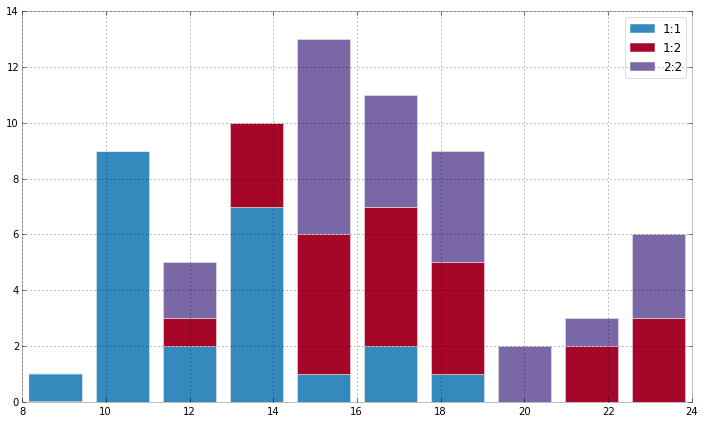

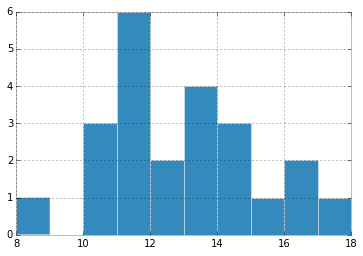

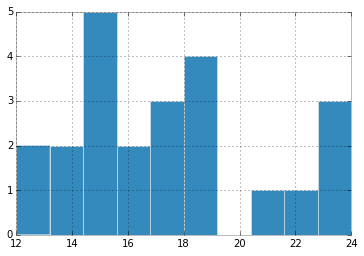

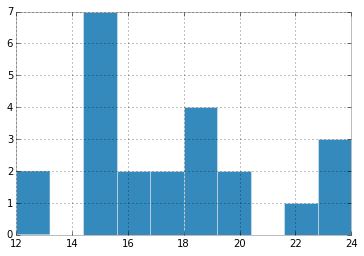

In [21]:
# print all_data["phase"]
import pandas as pd
from matplotlib.pyplot import *
%matplotlib inline
all_data = pd.read_csv(root + "/all_scores_bics_nstates_by_phase.csv")
from matplotlib.patches import Patch
zero = all_data[all_data.phase == 0]
one = all_data[all_data.phase == 1]
two = all_data[all_data.phase == 2]
get_values = lambda x: x["nstates_amp_and_mel"].values
figure(figsize=(12,7))
mappings = ['1:1', "1:2", "2:2"]
colors = [gca()._get_lines.color_cycle.next() for i in mappings] 
# print dir(colors)
# print colors
handles = [Patch(color=c, label=m) for c,m in zip(colors, mappings)]
hist([get_values(zero),get_values(one),get_values(two)], stacked=True, 
     color=colors)#, histtype="stepfilled")
legend(handles=handles)
for dataset in (get_values(zero), get_values(one), get_values(two)):
    figure()
    hist(dataset)

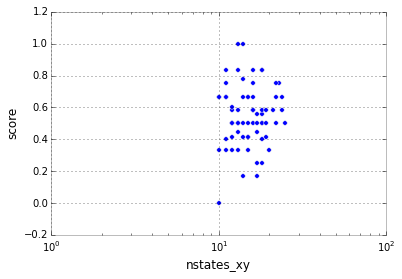

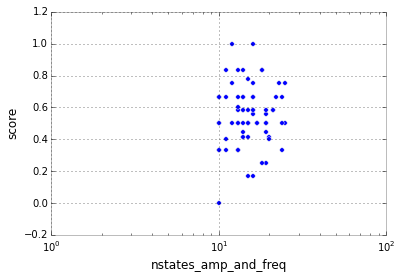

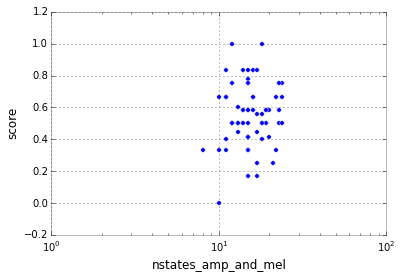

In [20]:
# %matplotlib inline
# print all_data['llh']
# scatter(all_data["score"], all_data["llh"])
import numpy as np
import matplotlib.pyplot as plt
def plot_trend(target_col, source_col):
    for unit in ("xy", "amp_and_freq", "amp_and_mel"):
        figure()
        scatter(all_data["%s_%s" % (source_col, unit)],all_data[target_col])
        ylabel(target_col)
        xlabel("%s_%s" % (source_col, unit))
        plt.gca().set_xscale("log")
#         plt.gca().set_yscale("log")

plot_trend("score", "nstates")

# figure()
# plot(np.divide(range(1,100),100.), np.log(np.divide(range(1,100),100.)))
# xlabel("X")
# ylabel("log(X)")
# print all_data["llh_xy"]
# print ids